In [1]:
import time
import os
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
import numpy as np
import tensorflow as tf


import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from keras import layers, losses
from keras.models import Sequential
from sklearn import metrics
from tqdm import tqdm
from keras.optimizers import Adam
from keras.layers import InputLayer, LSTM, Dense, RepeatVector, TimeDistributed, LayerNormalization, Dropout
from keras.models import Model

In [3]:
try:
    # enable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type == 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

## Data Loading

In [4]:
# Set the directories
DATA_DIR_SLOW = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaSlow.npy"
DATA_DIR_NORMAL = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaNormal.npy"
DATA_DIR_C_NAMES = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaColumnNames.npy"

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [5]:
# Load the files
data_normal = np.load(DATA_DIR_NORMAL)
data_slow = np.load(DATA_DIR_SLOW)
column_names = np.load(DATA_DIR_C_NAMES)

In [6]:
# Check the column names
print(column_names)

['action' 'machine_nameKuka Robot_apparent_power'
 'machine_nameKuka Robot_current' 'machine_nameKuka Robot_frequency'
 'machine_nameKuka Robot_phase_angle' 'machine_nameKuka Robot_power'
 'machine_nameKuka Robot_power_factor'
 'machine_nameKuka Robot_reactive_power' 'machine_nameKuka Robot_voltage'
 'sensor_id1_AccX' 'sensor_id1_AccY' 'sensor_id1_AccZ' 'sensor_id1_GyroX'
 'sensor_id1_GyroY' 'sensor_id1_GyroZ' 'sensor_id1_q1' 'sensor_id1_q2'
 'sensor_id1_q3' 'sensor_id1_q4' 'sensor_id1_temp' 'sensor_id2_AccX'
 'sensor_id2_AccY' 'sensor_id2_AccZ' 'sensor_id2_GyroX' 'sensor_id2_GyroY'
 'sensor_id2_GyroZ' 'sensor_id2_q1' 'sensor_id2_q2' 'sensor_id2_q3'
 'sensor_id2_q4' 'sensor_id2_temp' 'sensor_id3_AccX' 'sensor_id3_AccY'
 'sensor_id3_AccZ' 'sensor_id3_GyroX' 'sensor_id3_GyroY'
 'sensor_id3_GyroZ' 'sensor_id3_q1' 'sensor_id3_q2' 'sensor_id3_q3'
 'sensor_id3_q4' 'sensor_id3_temp' 'sensor_id4_AccX' 'sensor_id4_AccY'
 'sensor_id4_AccZ' 'sensor_id4_GyroX' 'sensor_id4_GyroY'
 'sensor_id4_GyroZ

## Data Setup

In [7]:
# prepare labels and separate them from data-slow
label_slow = data_slow[:,-1:] - 1
data_slow = data_slow[:,:-1]

In [8]:
# Find the features that have less variable values than given threshold
threshold = 31

unique = {}
for i in range(data_normal.shape[1]):
    classes = np.unique(data_normal[:,i])
    if len(classes) < threshold:
        unique[i] = [len(classes) , classes]
print(unique, len(unique))
delete_list = []
for i in range(data_normal.shape[1]):
    if i not in unique.keys():
        delete_list.append(False)
    else:
        delete_list.append(True)

{3: [5, array([49.902534, 49.951218, 50.      , 50.048878, 50.097847])], 30: [1, array([144.12])], 41: [2, array([120.3 , 144.12])], 52: [3, array([-175.86,    9.59,  144.12])], 63: [1, array([144.12])], 74: [1, array([180.24])], 85: [1, array([180.24])]} 7


In [9]:
# Take the features less variable than given threshold
data_normal_dr = np.delete(data_normal, delete_list, axis=1)
data_slow_dr = np.delete(data_slow, delete_list, axis=1)
print(f"Shape of slow data after basic feature selection: {data_slow_dr.shape} \nFor normal data: {data_normal_dr.shape}")

Shape of slow data after basic feature selection: (41538, 79) 
For normal data: (233792, 79)


In [10]:
# Normalization train on train set transform both
scaler = preprocessing.StandardScaler().fit(data_normal_dr)
data_train_scaled = scaler.transform(data_normal_dr)
data_test_scaled = scaler.transform(data_slow_dr)

In [11]:
#windows of 48 with stride 1
width_window = 48
data_train_all = np.array([data_train_scaled[i:i+width_window,:] for i in range(0, len(data_train_scaled)-width_window)])
data_test_all = np.array([data_test_scaled[i:i+width_window,:] for i in range(0, len(data_test_scaled)-width_window)])
print(f"train data shape: {data_train_all.shape} \n test data shape: {data_test_all.shape} ")

train data shape: (233744, 48, 79) 
 test data shape: (41490, 48, 79) 


In [12]:
# Shuffle the data
mix_data = True
seed = 0
if mix_data:
    data_train_all = tf.random.shuffle(data_train_all)
print(f"train data shape: {data_train_all.shape} \n")

train data shape: (233744, 48, 79) 



In [46]:
# First 60 percent for training, 20 percent for validation between 60-80, 20 percent for test from 80-100
percentage_train = 0.6
percentage_test = 1.
validation = [0.60, 0.80]
test = 0.80

# take part of data to gather results faster
data_train = data_train_all[0:int(percentage_train*data_train_all.shape[0]),:,:]
data_test = data_test_all[0:int(percentage_test*data_test_all.shape[0]),:,:]

# mixed test data 50-50
data_test_mixed = np.zeros((2*data_test.shape[0], data_test.shape[1], data_test.shape[2]))
data_test_mixed[0:int(data_test.shape[0]),:,:] += data_test
data_test_mixed[int(data_test.shape[0]):,:,:] += data_train_all[int(test*data_train_all.shape[0]): int(test*data_train_all.shape[0])+data_test.shape[0],:,:]

# set labels
label_test = label_slow[0:data_test.shape[0]]
label_test_mixed = np.zeros((data_test_mixed.shape[0], 1))
label_test_mixed[0:label_test.shape[0]] += label_test

# Validation data
data_validation = data_train_all[int(validation[0]*data_train_all.shape[0]): int(validation[1]*data_train_all.shape[0]),:,:]


print(f"train data shape: {data_train.shape} \ntest data shape: {data_test.shape} \nlabel shape: {label_test.shape} \n\ntest data prepared: {data_test_mixed.shape} \nlabel prepared: {label_test_mixed.shape} \n\ndata validation: {data_validation.shape}")

train data shape: (140246, 48, 79) 
test data shape: (41490, 48, 79) 
label shape: (41490, 1) 

test data prepared: (82980, 48, 79) 
label prepared: (82980, 1) 

data validation: (46749, 48, 79)


## Model

In [14]:
# set these variables before model creation

latent_size = 10
input_shape = data_train.shape[1:]
n_features = data_train.shape[2]
width_window = 48
dropout = False
layer_norm = True

In [15]:
# Autoencoder class
class Autoencoder(Model):
  def __init__(self, encoder, decoder, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = encoder
    self.decoder = decoder

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [32]:
# Encoder, Decoder, Discriminator functions

def build_model_enc():
    model = Sequential()
    model.add(LSTM(latent_size*16, activation='relu', input_shape=input_shape, return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*8, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*4, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*2, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size, activation='relu', return_sequences=False, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(RepeatVector(width_window))
    return model

def build_model_dec():
    model = Sequential()

    model.add(LSTM(latent_size, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*2, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*4, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*8, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*16, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(units=n_features)))
    return model


def make_discriminator_z_model():
    encoded = tf.keras.Input(shape=(width_window, latent_size))
    x = tf.keras.layers.Dense(128)(encoded)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    prediction = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=encoded, outputs=prediction)
    return model


def make_discriminator_x_model():
    inputs = tf.keras.layers.Input(shape=(width_window, 79))

    x = tf.keras.layers.Conv1D(filters=16, kernel_size=4, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv1D(filters=28, kernel_size=4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv1D(filters=48, kernel_size=4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    z = tf.keras.layers.Conv1D(filters=1, kernel_size=4, strides=1, padding='valid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=z)
    return model




# def build_model_disc_z():
#     model = Sequential()
#     #model.add(layers.Dense(256, activation="relu", input_shape=(width_window, latent_size)))
#     model.add(layers.Dense(64, activation="relu", input_shape=(width_window, latent_size)))
#     model.add(layers.Dense(64, activation="relu"))
#     #model.add(layers.Dense(16, activation="relu"))
#     model.add(layers.Dense(1, activation="sigmoid"))
#     return model
#
# def build_model_disc_x():
#     model = Sequential()
#     #model.add(layers.Dense(256, activation="relu", input_shape=(width_window, latent_size)))
#     model.add(layers.Dense(64, activation="relu", input_shape=input_shape))
#     model.add(layers.Dense(64, activation="relu"))
#     #model.add(layers.Dense(16, activation="relu"))
#     model.add(layers.Dense(1, activation="sigmoid"))
#     return model

## Adversarial Autoencoder - Build Models & Create loss functions

In [33]:
# build functions for models

def build_models():
    model_enc = build_model_enc()
    model_dec = build_model_dec()
    discriminator_z = make_discriminator_z_model()
    discriminator_x = make_discriminator_x_model()

    model_ae = Autoencoder(model_enc, model_dec, latent_size)
    model_ae.build(input_shape=(None, input_shape[0], input_shape[1]))

    return model_ae, discriminator_z, discriminator_x

def build_aae():
    model_ae, discriminator_z, discriminator_x = build_models()

    ae_optimizer = Adam(learning_rate=learning_rate_ae)
    dc_z_optimizer = Adam(learning_rate=learning_rate_disc)
    gen_z_optimizer = Adam(learning_rate=learning_rate_gen)
    dc_x_optimizer = Adam(learning_rate=learning_rate_disc)
    gen_x_optimizer = Adam(learning_rate=learning_rate_gen)

    try:
        with tf.device('/GPU'):
            #data_train = tf.convert_to_tensor(data_train, dtype=tf.int32)

            # discriminator z
            discriminator_z = discriminator_z
            discriminator_z.compile(optimizer=dc_z_optimizer, loss=discriminator_loss)
            discriminator_z.summary()

            # discriminator x
            discriminator_x = discriminator_x
            discriminator_x.compile(optimizer=dc_x_optimizer, loss=discriminator_loss)
            discriminator_x.summary()

            # auto encoder
            model_ae = model_ae
            model_ae.compile(optimizer=ae_optimizer, loss=autoencoder_loss)
            model_ae.summary()
    except RuntimeError as e:
        print(e)
    return model_ae , discriminator_z, discriminator_x, ae_optimizer, dc_z_optimizer, gen_z_optimizer, dc_x_optimizer, gen_x_optimizer

In [34]:
# Optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy() #from_logits=True
mse = tf.keras.losses.MeanSquaredError()
accuracy = tf.keras.metrics.BinaryAccuracy()

# Loss functions for autoencoder, discriminator and generator
def autoencoder_loss(inputs, reconstruction, loss_weight):
    weighted_mse_loss =  loss_weight * mse(inputs, reconstruction)
    return weighted_mse_loss

def discriminator_loss(real_output, fake_output, loss_weight):
    loss_real = cross_entropy(tf.ones_like(real_output), real_output)
    loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
    weighted_c_e = loss_weight * (loss_fake + loss_real)
    return weighted_c_e

def generator_loss(fake_output, loss_weight):
    weighted_c_e = loss_weight * cross_entropy(tf.ones_like(fake_output), fake_output)
    return weighted_c_e

In [35]:
# Train function for optimizing gradients for each batch
comment = False
def train_step(batch_x):
    ae_loss, dc_z_loss, dc_z_acc, gen_z_loss, dc_x_loss, dc_x_acc, gen_x_loss = 0,0,0,0,0,0,0
    # -------------------------------------------------------------------------------------------------------------
    # Autoencoder
    with tf.GradientTape() as ae_tape:
        encoded = model_ae.encoder(batch_x, training=True)
        decoded = model_ae.decoder(encoded, training=True)

        if comment is True : print(f"Train step: \nbatch_x: {batch_x.shape}, decoded: {decoded.shape}")
        # Autoencoder loss
        ae_loss = autoencoder_loss(batch_x, decoded, ae_loss_weight)

    ae_grads = ae_tape.gradient(ae_loss, model_ae.encoder.trainable_variables + model_ae.decoder.trainable_variables)
    ae_optimizer.apply_gradients(zip(ae_grads, model_ae.encoder.trainable_variables + model_ae.decoder.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    if Z:
        # Discriminator Z
        with tf.GradientTape() as dc_tape_z:
            real_distribution = tf.random.normal([batch_x.shape[0], width_window, latent_size], mean=0.0, stddev=1.0)
            encoded = model_ae.encoder(batch_x, training=True)

            dc_real = discriminator_z(real_distribution, training=True)
            dc_fake = discriminator_z(encoded, training=True)

            # Discriminator Loss
            dc_z_loss = discriminator_loss(dc_real, dc_fake, dc_loss_weight)

            # Discriminator Acc
            dc_z_acc = accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                              tf.concat([dc_real, dc_fake], axis=0))

        dc_grads_z = dc_tape_z.gradient(dc_z_loss, discriminator_z.trainable_variables)
        dc_z_optimizer.apply_gradients(zip(dc_grads_z, discriminator_z.trainable_variables))

        # -------------------------------------------------------------------------------------------------------------
        # Generator (Encoder) Z
        with tf.GradientTape() as gen_tape_z:
            encoded = model_ae.encoder(batch_x, training=True)
            gen_output = discriminator_z(encoded, training=True)

            # Generator loss
            gen_z_loss = generator_loss(gen_output, gen_loss_weight)

        gen_grads_z = gen_tape_z.gradient(gen_z_loss, model_ae.encoder.trainable_variables)
        gen_z_optimizer.apply_gradients(zip(gen_grads_z, model_ae.encoder.trainable_variables))
        # -------------------------------------------------------------------------------------------------------------
    if X:
        # Discriminator X
        with tf.GradientTape() as dc_tape_x:
            real_distribution = tf.random.normal([batch_x.shape[0], width_window, latent_size], mean=0.0, stddev=1.0)
            encoded = model_ae.encoder(batch_x, training=True)
            decoded = model_ae.decoder(encoded, training=True)

            x_real_dist = discriminator_x(batch_x, training=True)
            x_const_dist = discriminator_x(decoded, training=True)

            # Discriminator Loss
            dc_x_loss = discriminator_loss(x_real_dist, x_const_dist, dc_loss_weight)

            # Discriminator Acc
            dc_x_acc = accuracy(tf.concat([tf.ones_like(x_real_dist), tf.zeros_like(x_const_dist)], axis=0),
                              tf.concat([x_real_dist, x_const_dist], axis=0))

        dc_grads_x = dc_tape_x.gradient(dc_x_loss, discriminator_x.trainable_variables)
        dc_x_optimizer.apply_gradients(zip(dc_grads_x, discriminator_x.trainable_variables))

        # -------------------------------------------------------------------------------------------------------------
        # Generator (Encoder) X
        with tf.GradientTape() as gen_tap_x:
            encoded = model_ae.encoder(batch_x, training=True)
            decoded = model_ae.decoder(encoded, training=True)

            gen_output = discriminator_x(decoded, training=True)

            # Generator loss
            gen_x_loss = generator_loss(gen_output, gen_loss_weight)

        gen_grads_x = gen_tap_x.gradient(gen_x_loss, model_ae.decoder.trainable_variables)
        gen_x_optimizer.apply_gradients(zip(gen_grads_x, model_ae.decoder.trainable_variables))

    return ae_loss, dc_z_loss, dc_z_acc, gen_z_loss, dc_x_loss, dc_x_acc, gen_x_loss

In [49]:
# Regularization on latent code (Z) and/or reconstructed time-series (X)
X = True
Z = False

# Learning rates and loss weights to be able to keep balance between models
learning_rate_ae = 1e-4
learning_rate_gen = 5e-5
learning_rate_disc = 5e-6
max_learning_rate = 5e-5

ae_loss_weight = 1.
gen_loss_weight = 1.
dc_loss_weight = 1.

batch_size = 128

# bould adversarial autoencoder
model_ae , discriminator_z, discriminator_x, ae_optimizer, dc_z_optimizer, gen_z_optimizer, dc_x_optimizer, gen_x_optimizer = build_aae()

# split to data to batches
train_dataset = tf.data.Dataset.from_tensor_slices(data_train)
train_dataset = train_dataset.batch(batch_size)

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 48, 10)]          0         
                                                                 
 dense_57 (Dense)            (None, 48, 128)           1408      
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 48, 128)           0         
                                                                 
 dense_58 (Dense)            (None, 48, 128)           16512     
                                                                 
 leaky_re_lu_71 (LeakyReLU)  (None, 48, 128)           0         
                                                                 
 dense_59 (Dense)            (None, 48, 1)             129       
                                                                 
Total params: 18,049
Trainable params: 18,049
Non-trainabl

In [ ]:
# And training phase
n_epochs = 30
train_autoencoder_loss = []
train_generator_loss_z = []
train_discriminator_loss_z = []
train_discriminator_acc_z = []

train_generator_loss_x = []
train_discriminator_loss_x = []
train_discriminator_acc_x = []

# if validation information needed (it takes more time for training)
# test_cost = []
# train_cost = []
# validation_cost = []

# cyclic learning rate variables
# n_samples = data_train.shape[0]
# step_size = 2 * np.ceil(n_samples / batch_size)
# global_step = 0

# keep the best loss of autoencoder
last_best = 9
last_loss = 10
shape = F"{latent_size}_5_layer_AAE_0"
checkpoint_dir = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints"
model_dir = f"{checkpoint_dir}/{n_epochs}_{shape}"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
print(f"Weights will be saved in: {model_dir}")
for epoch in range(n_epochs):
    start = time.time()

    # Save the best model
    if epoch != 0 and (last_best>last_loss):
        best_path = f"{model_dir}/best"
        if not os.path.exists(best_path):
            os.mkdir(best_path)
            os.mkdir(f"{best_path}/AE")
            if X : os.mkdir(f"{best_path}/DISC_X")
            if Z : os.mkdir(f"{best_path}/DISC_Z")

        # Save the weight for future test and further training
        model_ae.save_weights(f"{best_path}/AE/model")
        if X : discriminator_x.save_weights(f"{best_path}/DISC_X/model")
        if Z : discriminator_z.save_weights(f"{best_path}/DISC_Z/model")

        print(f"Saved! AE loss has been decreased from {last_best} to {epoch_ae_loss_avg.result()}.")
        last_best = epoch_ae_loss_avg.result()


    # Save every 5 epoch
    elif epoch != 0 and epoch%5==0:
        epoch_path = f"{model_dir}/{epoch+1}"
        if not os.path.exists(epoch_path):
            os.mkdir(epoch_path)
            os.mkdir(f"{epoch_path}/AE")
            if X : os.mkdir(f"{epoch_path}/DISC_X")
            if Z : os.mkdir(f"{epoch_path}/DISC_Z")

        # Save the weight for future test and further training
        model_ae.save_weights(f"{epoch_path}/model")
        if X : discriminator_x.save_weights(f"{epoch_path}/DISC_X/model")
        if Z : discriminator_z.save_weights(f"{epoch_path}/DISC_Z/model")

        print(f"Saved!")


    # average loss calculator for batches
    epoch_ae_loss_avg = tf.metrics.Mean()
    epoch_dc_z_loss_avg = tf.metrics.Mean()
    epoch_dc_z_acc_avg = tf.metrics.Mean()
    epoch_gen_z_loss_avg = tf.metrics.Mean()
    epoch_dc_x_loss_avg = tf.metrics.Mean()
    epoch_dc_x_acc_avg = tf.metrics.Mean()
    epoch_gen_x_loss_avg = tf.metrics.Mean()
    for batch, (batch_x) in enumerate(train_dataset):
        # -------------------------------------------------------------------------------------------------------------
        #Calculate cyclic learning rate
        # global_step = global_step + 1
        # cycle = np.floor(1 + global_step / (2 * step_size))
        # x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        # clr = learning_rate_ae + (max_learning_rate - learning_rate_ae) * max(0, 1 - x_lr)
        # ae_optimizer.lr = clr
        # dc_optimizer.lr = 0.05 * clr
        # gen_optimizer.lr = 0.1 * clr

        # Calculate the losses and optimize them
        ae_loss, dc_z_loss, dc_z_acc, gen_z_loss, dc_x_loss, dc_x_acc, gen_x_loss = train_step(batch_x)

        epoch_ae_loss_avg(ae_loss)
        epoch_dc_z_loss_avg(dc_z_loss)
        epoch_dc_z_acc_avg(dc_z_acc)
        epoch_gen_z_loss_avg(gen_z_loss)
        epoch_dc_x_loss_avg(dc_x_loss)
        epoch_dc_x_acc_avg(dc_x_acc)
        epoch_gen_x_loss_avg(gen_x_loss)


    # Some feedback information
    last_loss = epoch_ae_loss_avg.result()
    epoch_time = time.time() - start
    print(
        '{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_Z_LOSS: {:.4f} DC_Z_ACC: {:.4f} GEN_Z_LOSS: {:.4f} DC_X_LOSS: {:.4f} DC_X_ACC: {:.4f} GEN_X_LOSS: {:.4f}'
        .format(epoch + 1 , epoch_time / 60,
                epoch_time * (n_epochs - epoch) / 60,
                epoch_ae_loss_avg.result(),
                epoch_dc_z_loss_avg.result(),
                epoch_dc_z_acc_avg.result(),
                epoch_gen_z_loss_avg.result(),
                epoch_dc_x_loss_avg.result(),
                epoch_dc_x_acc_avg.result(),
                epoch_gen_x_loss_avg.result()))
    train_autoencoder_loss.append(epoch_ae_loss_avg.result())
    train_generator_loss_z.append(epoch_gen_z_loss_avg.result())
    train_discriminator_loss_z.append(epoch_dc_z_loss_avg.result())
    train_discriminator_acc_z.append(epoch_dc_z_acc_avg.result())
    train_generator_loss_x.append(epoch_gen_x_loss_avg.result())
    train_discriminator_loss_x.append(epoch_dc_x_loss_avg.result())
    train_discriminator_acc_x.append(epoch_dc_x_acc_avg.result())

    # Validation information
    # -------------------------------------------------------------------------------------------------------------
    # train_decoded = model_ae.predict(data_train)
    # cost_train = np.mean(np.abs(train_decoded - data_train), axis=1)
    # train_cost.append(cost_train)
    # print(f"        Mean cost of train: {np.mean(np.abs(train_decoded - data_train))}")
    #
    # test_decoded = model_ae.predict(data_test)
    # cost_test = np.mean(np.abs(test_decoded - data_test), axis=1)
    # test_cost.append(cost_test)
    # print(f"        Mean cost of test: {np.mean(np.abs(test_decoded - data_test))}")
    #
    # val_decoded = model_ae.predict(data_validation)
    # cost_val = np.mean(np.abs(val_decoded - data_validation), axis=1)
    # validation_cost.append(cost_val)
    # print(f"        Mean cost of validation: {np.mean(np.abs(val_decoded - data_validation))}")


Weights will be saved in: /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/30_10_5_layer_AAE_0


### Save the model

In [54]:
# Save the trained weights
shape = f"{latent_size}_5_layer_AAE"
checkpoint_dir = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints"
model_dir = f"{checkpoint_dir}/{learning_rate_ae}_{n_epochs}_{shape}"

os.mkdir(f"{model_dir}")
model_ae.save_weights(f"{model_dir}/model")

In [134]:
shape = f"{latent_size}_5_layer_AAE_123"
model_dir = f"{checkpoint_dir}/{n_epochs}_{shape}"

In [26]:
# save the loss changes
np.save(f"{model_dir}/ae_loss.npy", train_autoencoder_loss)
np.save(f"{model_dir}/gen_loss.npy", train_generator_loss_x)
np.save(f"{model_dir}/disc_loss.npy", train_discriminator_loss_x)

np.save(f"{model_dir}/disc_acc.npy", train_discriminator_acc_x)

## Losses and Costs during training

In [27]:
# test_cost_avg = [np.mean(np.abs(i)) for i in test_cost]
# train_cost_avg = [np.mean(np.abs(i)) for i in train_cost]
# validation_cost_avg = [np.mean(np.abs(i)) for i in validation_cost]

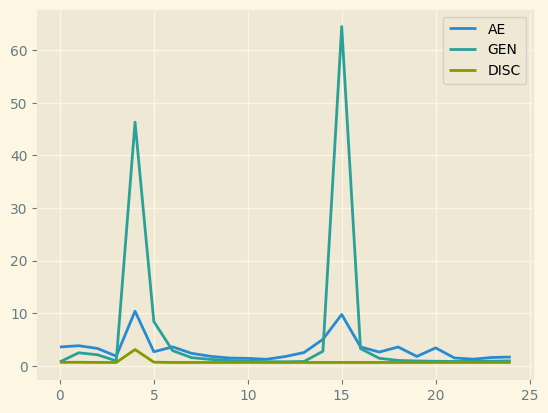

In [100]:
# plt.plot(test_cost_avg, label="test")
# plt.plot(train_cost_avg, label="train")
# plt.plot(validation_cost_avg, label="val")
# plt.legend()
# plt.show()

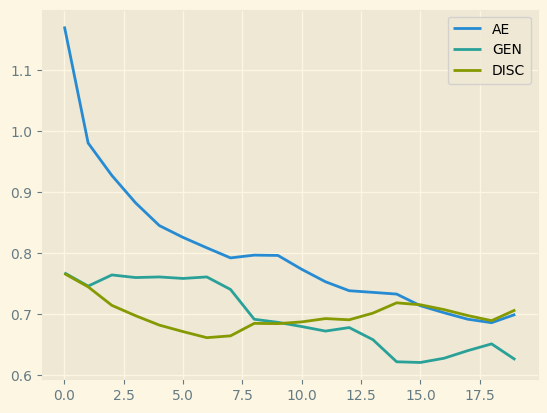

In [55]:
# Losses during training
plt.plot(train_autoencoder_loss, label="AE")
plt.plot(train_generator_loss, label="GEN")
plt.plot(train_discriminator_loss, label="DISC")
plt.legend()
plt.show()

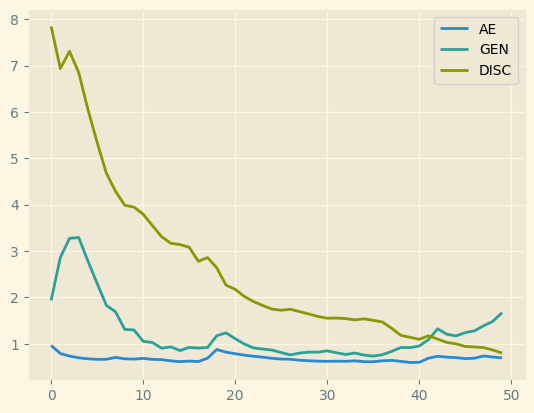

In [137]:
# Losses during training
plt.plot(train_autoencoder_loss, label="AE")
plt.plot(train_generator_loss_x, label="GEN")
plt.plot(train_discriminator_loss_x, label="DISC")
plt.legend()
plt.show()

## Investigation & Evaluation

In [58]:
# some results with average reconstruction cost
p_train = model_ae.predict(data_train)
difference_train = np.abs(p_train - data_train)
cost_train = np.mean(np.abs(p_train - data_train), axis=1)
print(f"mean: {np.mean(difference_train)}")


p_test = model_ae.predict(data_test)
difference_test = np.abs(p_test - data_test)
cost_test = np.mean(np.abs(p_test - data_test), axis=1)
print(f"mean: {np.mean(difference_test)}")

2023-07-11 17:05:42.138183: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4383/4383 [==============================] - 183s 42ms/step
mean: 0.544943258091213
1297/1297 [==============================] - 55s 42ms/step
mean: 0.5573903051488622


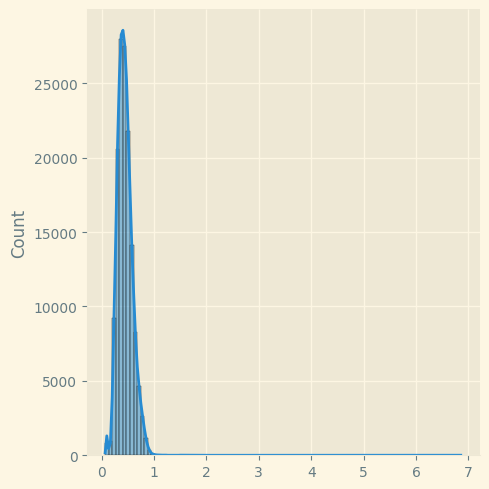

In [59]:
sns.displot(cost_train[:,32], bins=100, kde=True, label="Train")

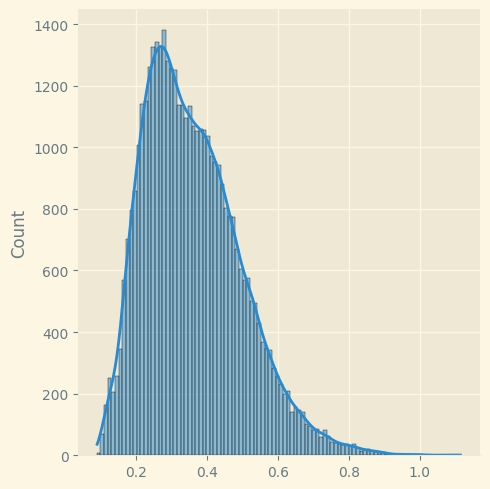

In [60]:
sns.displot(cost_test[:,32], bins=100, kde=True)

2594/2594 [==============================] - 110s 43ms/step
mean: 0.5513310817976536


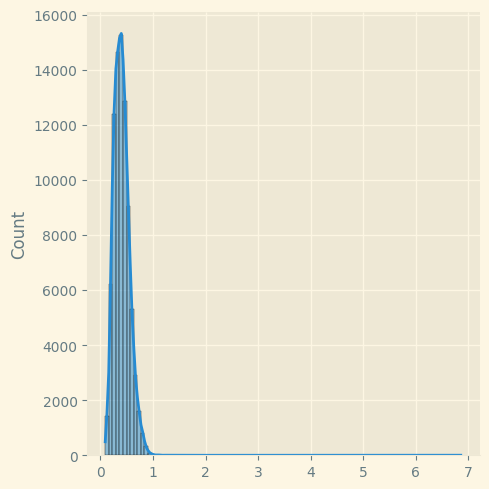

In [61]:
# Prepared test data
p_test_mixed = model_ae.predict(data_test_mixed)

difference_test_mixed = np.abs(p_test_mixed - data_test_mixed)
print(f"mean: {np.mean(difference_test_mixed)}")

cost_test_mixed = np.mean(np.abs(p_test_mixed - data_test_mixed), axis=1)
sns.displot(cost_test_mixed[:,32], bins=100, kde=True)

### PA%K

In [68]:
# PAK function to make adjustments on predictions
def pak(scores, targets, thres, k=20):
    """

    :param scores: anomaly scores (mean reconstruction cost for features)
    :param targets: target labels (1-0)
    :param thres: anomaly threshold
    :param k: PA%K ratio, 0 equals to conventional point adjust and 100 equals to original predictions
    :return: point_adjusted predictions
    """
    scores = np.array(scores)
    thres = np.array(thres)

    predicts = scores > thres
    actuals = targets > 0.01

    one_start_idx = np.where(np.diff(actuals, prepend=0) == 1)[0]
    zero_start_idx = np.where(np.diff(actuals, prepend=0) == -1)[0]

    assert len(one_start_idx) == len(zero_start_idx) + 1 or len(one_start_idx) == len(zero_start_idx)

    if len(one_start_idx) == len(zero_start_idx) + 1:
        zero_start_idx = np.append(zero_start_idx, len(predicts))

    for i in range(len(one_start_idx)):
        if predicts[one_start_idx[i]:zero_start_idx[i]].sum() > k / 100 * (zero_start_idx[i] - one_start_idx[i]):
            predicts[one_start_idx[i]:zero_start_idx[i]] = 1

    return predicts

In [69]:
# Evaluate function which gives results with comparison of with PAK function and without it
def evaluate(scores, targets, pa=True, interval=50, k=40):
    """
    :param scores: list or np.array or tensor, anomaly score
    :param targets: list or np.array or tensor, target labels
    :param pa: True/False
    :param interval: threshold search interval
    :param k: PA%K threshold
    :return: results dictionary
    """
    assert len(scores) == len(targets)

    results = {}

    try:
        scores = np.asarray(scores)
        targets = np.asarray(targets)
    except TypeError:
        scores = np.asarray(scores.cpu())
        targets = np.asarray(targets.cpu())

    precision, recall, threshold = metrics.precision_recall_curve(targets, scores)
    f1_score = 2 * precision * recall / (precision + recall + 1e-30)

    #print(f"WITHOUT PA: \nMean precision: {np.mean(precision)} \nMean recall: {np.mean(recall)} \nMean F1 score: {np.mean(f1_score)}")

    results['best_f1_wo_pa'] = np.max(f1_score)
    results['f1_scores'] = f1_score
    results['best_precision_wo_pa'] = precision[np.argmax(f1_score)]
    results['best_recall_wo_pa'] = recall[np.argmax(f1_score)]
    results['prauc_wo_pa'] = metrics.average_precision_score(targets, scores)
    try:
        results['auc_wo_pa'] = metrics.roc_auc_score(targets, scores)
    except ValueError:
        pass


    if pa:
        # find F1 score with optimal threshold of best_f1_wo_pa
        pa_scores = pak(scores, targets, threshold[np.argmax(f1_score)], k)
        results['raw_f1_w_pa'] = metrics.f1_score(targets, pa_scores)
        results['raw_precision_w_pa'] = metrics.precision_score(targets, pa_scores)
        results['raw_recall_w_pa'] = metrics.recall_score(targets, pa_scores)

        # find best F1 score with varying thresholds
        if len(scores) // interval < 1:
            ths = threshold
        else:
            ths = [threshold[interval*i] for i in range(len(threshold)//interval)]
        pa_f1_scores = [metrics.f1_score(targets, pak(scores, targets, th, k)) for th in tqdm(ths)]
        pa_f1_scores = np.asarray(pa_f1_scores)
        results['best_f1_w_pa'] = np.max(pa_f1_scores)
        results['best_f1_th_w_pa'] = ths[np.argmax(pa_f1_scores)]
        pa_scores = pak(scores, targets, ths[np.argmax(pa_f1_scores)], k)
        results['best_precision_w_pa'] = metrics.precision_score(targets, pa_scores)
        results['best_recall_w_pa'] = metrics.recall_score(targets, pa_scores)
        results['pa_f1_scores'] = pa_f1_scores

    return results

In [71]:
# For model predictions
scores = np.mean(cost_test_mixed, axis=1)
targets = label_test_mixed.ravel()

In [72]:
result = evaluate(scores, targets, k=50)

mean_f1_wo_pa = np.mean(result["f1_scores"])
mean_f1_w_pa = np.mean(result["pa_f1_scores"])
print(f"mean F1 score without PA: {mean_f1_wo_pa} \nmean F1 score with PA: {mean_f1_w_pa}")

100%|██████████| 1659/1659 [00:37<00:00, 44.65it/s]


mean F1 score without PA: 0.4721781635440042 
mean F1 score with PA: 0.5523123678925695


In [67]:
result

{'best_f1_wo_pa': 0.6681159770364823,
 'f1_scores': array([0.66666667, 0.66667202, 0.66667738, ..., 0.        , 0.        ,
        0.        ]),
 'best_precision_wo_pa': 0.5016383135647526,
 'best_recall_wo_pa': 0.9999758978067004,
 'prauc_wo_pa': 0.57936106655686,
 'auc_wo_pa': 0.5208207607195943,
 'raw_f1_w_pa': 0.6681267009130581,
 'raw_precision_w_pa': 0.5016443391207622,
 'raw_recall_w_pa': 1.0,
 'best_f1_w_pa': 0.9985920069316582,
 'best_f1_th_w_pa': 0.805729185583551,
 'best_precision_w_pa': 0.9971879731775903,
 'best_recall_w_pa': 1.0,
 'pa_f1_scores': array([6.66672023e-01, 6.66725588e-01, 6.66779163e-01, ...,
        4.33536453e-04, 3.37276253e-04, 4.81939324e-05])}